In [1]:
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from model.unet_single_inference import UNetSingleInference

In [2]:
# Input Image
img_path = 'ex_B.jpg'
img_filename = os.path.basename(img_path).replace('.jpg', '')
save_folder = './'+img_filename+'/'

if not os.path.exists(save_folder):
    os.makedirs(save_folder)

img = cv2.imread(img_path)

In [3]:
# original image save
save_img = Image.fromarray(img)
save_img.save(save_folder+'1-original.jpg')

In [4]:
# image binary
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
save_img = Image.fromarray(img)
save_img.save(save_folder+'2-binary.jpg')

In [5]:
# resize 1440*1024
pil_image = Image.fromarray(img)
resized_pil_image = pil_image.resize((1440, 1024), Image.LANCZOS)
re_img = np.array(resized_pil_image)
save_img = Image.fromarray(re_img)
save_img.save(save_folder+'3-resize.jpg')

In [6]:
# Center Crop
width, height = resized_pil_image.size
if width < 1440 or height < 1024:
    resized_pil_image = resized_pil_image.resize((1440, 1024), Image.LANCZOS)
    width, height = resized_pil_image.size

new_size = 512
left = int((width - new_size) / 2)
top = int((height - new_size) / 2)
right = int(left + new_size)
bottom = int(top + new_size)

cropped = resized_pil_image.crop((left, top, right, bottom))
cropped = np.asarray(cropped)
save_img = Image.fromarray(cropped)
save_img.save(save_folder+'4-center_crop.jpg')

In [7]:
# bilateralFilter
bifil_img = cv2.bilateralFilter(cropped, -1, 10, 10)
save_img = Image.fromarray(bifil_img)
save_img.save(save_folder+'5-filter.jpg')

In [8]:
# dilation
kernel_size = (2,2)
kernel = np.ones(kernel_size, np.uint)
di_img = cv2.dilate(bifil_img, kernel, 1)
save_img = Image.fromarray(di_img)
save_img.save(save_folder+'6-dilation.jpg')

In [9]:
# model - UNet
ckpt_dir = './ckpt/model_epoch50.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if_manager = UNetSingleInference(model_path=ckpt_dir, device=device)
output = if_manager.inference(di_img)
output_img = (output[0, :, :, 0] * 255).astype(np.uint8)
save_img = Image.fromarray(output_img)
save_img.save(save_folder+'7-seg_output.jpg')

c:\Users\song\Desktop\my_seah\model\unet_single_inference.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(model_path, map_location=torch.device(

In [10]:
# Contour Detection
# No need (squeze, binary)
draw_img = output_img.copy()
contours, _ = cv2.findContours(draw_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
draw_img = cv2.cvtColor(draw_img, cv2.COLOR_GRAY2BGR)  

In [11]:
# when not success contour detection
num_contours = len(contours)
if num_contours >= 2:
    pro_di_img = (di_img[ :, :] * 255).astype(np.uint8)
    inverted_img = cv2.bitwise_not(pro_di_img)
    save_img = Image.fromarray(inverted_img)
    save_img.save(save_folder+img_filename+'.jpg')
    
    
else:
    output = if_manager.inference(bifil_img)
    output_img = (output[0, :, :, 0] * 255).astype(np.uint8)
    save_img = Image.fromarray(output_img)
    save_img.save(save_folder+'7-seg_output.jpg')

    draw_img = output_img.copy()
    contours, _ = cv2.findContours(draw_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    draw_img = cv2.cvtColor(draw_img, cv2.COLOR_GRAY2BGR)

    pro_di_img = (bifil_img[ :, :] * 255).astype(np.uint8)
    inverted_img = cv2.bitwise_not(pro_di_img)
    save_img = Image.fromarray(inverted_img)
    save_img.save(save_folder+img_filename+'.jpg')

In [12]:
cv2.drawContours(draw_img, contours, -1, (0, 255, 0), 2)
save_img = Image.fromarray(draw_img)
save_img.save(save_folder+'8-contour.jpg')

Number of contours detected: 12


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

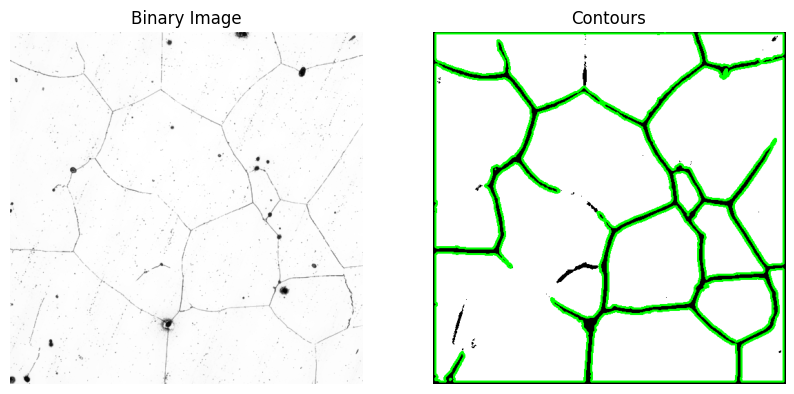

In [13]:
num_contours = len(contours)
print("Number of contours detected:", num_contours)

plt.figure(figsize=(10, 5))

# 이진화된 이미지
plt.subplot(1, 2, 1)
plt.title('Binary Image')
plt.imshow(inverted_img, cmap='gray')
plt.axis('off')

# 컨투어가 그려진 이미지
plt.subplot(1, 2, 2)
plt.title('Contours')
plt.imshow(draw_img)
plt.axis('off')

In [15]:
img_filename

'ex_B'

In [14]:
image_id = 1
category_id = 1

images = [{
    "id": image_id,
    "file_name": img_filename,
    "height": height,
    "width": width
}]

categories = [{
    "id": category_id,
    "name": "object",
    "supercategory": "none"
}]

annotations = []
annotation_id = 1

for contour in contours:
    seg_ = contour.flatten().tolist()
    x, y, w, h = cv2.boundingRect(contour)
    bbox = [x, y, w, h]
    area = cv2.contourArea(contour)
    annotation = {
        "id": annotation_id,
        "image_id": image_id,
        "category_id": category_id,
        "segmentation": [seg_],
        "area": area,
        "bbox": bbox,
        "iscrowd": 0
    }
    annotations.append(annotation)
    annotation_id += 1

coco_format = {
    "images": images,
    "annotations": annotations,
    "categories": categories
}

json_path = save_folder+img_filename+'.json'
with open(json_path, 'w') as json_file:
    json.dump(coco_format, json_file, indent=4)